# Performance Analysis of Model

This notebook will guide through my performance analysis of the model.

We'll target a few questions:
- How well does the model perform?
- What assumptions are made?
- What does the model perform better on? What about the poor ones?

## Preparation

As usual, we'll load relevant libraries and ...
- Load our test data
- Load our model

In [3]:
import sys

import pandas as pd

sys.path.append("../data_ppy_sh_to_csv/")
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

from opal.score.collaborative_filtering.lit_neu_mf_net import LitNeuMFNet
from opal.score.dataset.datamodule import ScoreDataModule

dm = ScoreDataModule(
    ds_yyyy_mm="2022_12", batch_size=256, m_min_support=50, u_min_support=50,
    score_bounds=(7.5e5, 1e6),
)
dm.setup()

E:\Repositories\PycharmProjects\opal\models\..\opal\score\dataset\datamodule.py:73: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_map = pd.read_csv(csv_map)


In [6]:
net = LitNeuMFNet.load_from_checkpoint(
    "version_64_64_8_acc/checkpoints/epoch=2-step=6144.ckpt",
    # "version_256_256_32_acc/checkpoints/epoch=6-step=14336.ckpt",
    uid_no=dm.n_uid,
    mid_no=dm.n_mid,

    mf_emb_dim=64,
    mlp_emb_dim=64,
    mlp_chn_out=8,
    # mf_emb_dim=256,
    # mlp_emb_dim=256,
    # mlp_chn_out=32,
    scaler=dm.scaler_accuracy,
    lr=0.005
)
# Set to evaluate mode (no gradient update)
net.eval()
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='cpu',
    limit_train_batches=512,
    limit_val_batches=32,
    limit_predict_batches=16,
    log_every_n_steps=15
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Predicting
We'll use our validation data to predict.

In [7]:
%%capture
y = trainer.predict(net, datamodule=dm)
y_preds = []
y_trues = []
for y_pred, y_true in trainer.predict(net, datamodule=dm):
    y_preds.append(y_pred)
    y_trues.append(y_true)
y_preds = np.stack(y_preds).flatten()
y_trues = np.stack(y_trues).flatten()

Missing logger folder: E:\Repositories\PycharmProjects\opal\models\lightning_logs


# Analysis

We'll firstly do some quick viz to get an intuition of the data

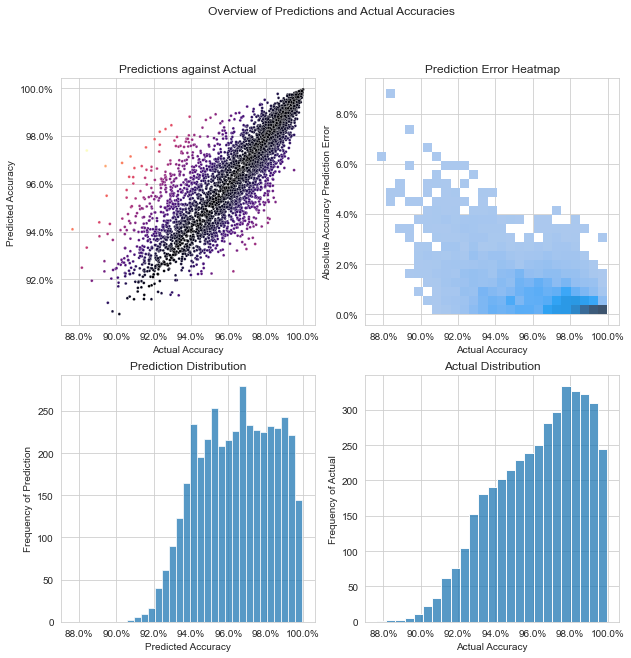

In [8]:
import seaborn as sns
import matplotlib.ticker as mtick

plt.figure(figsize=(10, 10))
plt.suptitle("Overview of Predictions and Actual Accuracies")

ax1 = plt.subplot(221)
sns.scatterplot(x=y_trues, y=y_preds, s=8, c=np.abs(y_trues - y_preds),
                cmap='magma')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Predictions against Actual")
plt.xlabel("Actual Accuracy")
plt.ylabel("Predicted Accuracy")

ax2 = plt.subplot(222)
ax2.sharex(ax1)
sns.histplot(x=y_trues, y=np.abs(y_preds - y_trues), bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Prediction Error Heatmap")
plt.xlabel("Actual Accuracy")
plt.ylabel("Absolute Accuracy Prediction Error")

ax3 = plt.subplot(223)
ax3.sharex(ax1)
sns.histplot(x=y_preds, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Prediction Distribution")
plt.xlabel("Predicted Accuracy")
plt.ylabel("Frequency of Prediction")

ax4 = plt.subplot(224)
ax4.sharex(ax1)
sns.histplot(x=y_trues, bins=25)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Actual Distribution")
plt.xlabel("Actual Accuracy")
plt.ylabel("Frequency of Actual")

plt.show()

**Biases Correction**

If you've seen my previous analysis, you'll see that our predictions for lower (actual) accuracies are biased.
This is because our model assumes a normal distribution for our input data, however, it's actually heavily skewed.
Despite the sigmoid correction, it was still insufficient to correct the biases, thus, alternatively, we used a `QuantileTransformer` to force transform data into a normal distribution.

**Score Limiting**

We limited the input to only have scores > 750,000. Thus, accuracies taper around 90.00%.
This may have caused the model to not be able to predict scores beyond 90.00%, however we're not that interested in those predictions.

Despite that, it may prove to be more useful if we included those, so we'll circle back next time.


## Analysis of input

We also have our `DataFrame` of input data, let's take a glance

In [6]:
df = dm.df

In [7]:
df.head()

,uid,mid,score,accuracy,uid_le,mid_le
0,437945/2014,192345/0,795309.0,-1.435483,2521,2118
1,623773/2014,192345/0,931373.0,0.055575,2867,2118
2,1192936/2014,192345/0,761921.0,-2.247778,629,2118
3,1326008/2014,192345/0,878780.0,-0.998840,970,2118
4,1517607/2014,192345/0,984948.0,0.552689,1325,2118


We see 6 columns, the first 2 are `str` columns, for `LabelEncoder` to encode, the result is the last 2.

E.g.

`uid=U/YYYY` means the user, with user id `U`, with the score in year `YYYY`.

`mid=M/S` means the map, with beatmap id `M` with speed of map `S`.
- `S=1`: Double Time
- `S=0`: Normal Time
- `S=-1`: Half Time

Note that our accuracies are quantile transformed.

# Performance of Model

Now, let's figure out how well the model performed on the prediction.

In [8]:
f"The MAE is {np.abs(y_preds - y_trues).mean():.2%} with RMSE {((y_preds - y_trues) ** 2).mean() ** 0.5:.2%}"

'The MAE is 0.85% with RMSE 1.20%'

Sort of tells us that the general error is around 1%, which is acceptable.

Let's find out the errors of each percentage

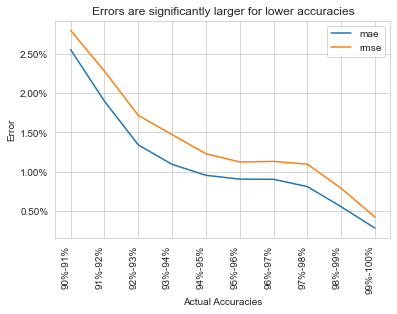

In [9]:
def get_error(y_preds, y_trues, a, b):
    y_preds = y_preds[(y_trues >= a) & (y_trues < b)]
    y_trues = y_trues[(y_trues >= a) & (y_trues < b)]

    return np.abs(y_preds - y_trues).mean(), ((y_preds - y_trues) ** 2).mean() ** 0.5


errors = []
bounds = np.linspace(0.9, 1, 11)
for a, b in zip(bounds[:-1], bounds[1:]):
    mae, rmse = get_error(y_preds, y_trues, a, b)
    errors.append([f"{a:.0%}-{b:.0%}", mae, rmse])

df_errors = pd.DataFrame(errors, columns=['bounds', 'mae', 'rmse'])
sns.lineplot(data=df_errors, x='bounds', y='mae', label='mae')
sns.lineplot(data=df_errors, x='bounds', y='rmse', label='rmse')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.title("Errors are significantly larger for lower accuracies")
plt.xlabel("Actual Accuracies")
plt.ylabel("Error")
_ = plt.xticks(rotation=90, ha='right')

With domain expert input, it's logical. Higher accuracies are difficult to improve, thus even small deviations can imply large skill gaps.
Vice versa.

## Root Cause Analysis

Next, we take a look at predictions that do well, and those that don't.


In [30]:
import torch


def inv(x):
    return net.scaler.inverse_transform(x)


df_sample = df.sample(1000)[['uid_le', 'mid_le', 'accuracy']]
sample_x = torch.as_tensor(df_sample[['uid_le', 'mid_le']].values)
df_sample['pred'] = inv(net(sample_x[:, 0:1], sample_x[:, 1:2]).detach().numpy())
df_sample['pred_error'] = inv(df_sample[['accuracy']].values) - df_sample[['pred']]
df_sample['accuracy'] = inv(df_sample[['accuracy']].values)